In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Capacity Requirements

This notebook predicts the maximum memory capacity and expected capacity requirement of Fashion MNIST dataset. 

In [4]:
# Loading Fashion MNIST dataset
fashion_mnist = pd.read_csv('data/train.csv')
fashion_mnist.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In Fashion MNIST dataset, the first column is the label [0 - 9], and the rest 784 columns refer to the 784 pixels in a 28 x 28 grayscale image. We have in total 600,000 training samples.  

## Algorithm 1

The algorithm implements the pseudo code in Chapter 9 of prof. Gerald's textbook. It is similar to what's presented in [nntailoring capacity requirement](https://github.com/fractor/nntailoring/blob/master/capacityreq/capacityreq.py). This algorithm assumes that all d dimensions are in equilibrium and can be modeled with equal weights in the dot product. In other wrods, we can fix the weights to 1 and train only the biases. To train the bias, we create a two-column table containing the 1-weighted sums of the feature vector adn the corresponding label. Then we sort the table by the first column (sums). Finally, we iterate through the sorted table and count the need for a threshold every time a class change occurs between two neighboring rows. This is equivalent of adding a neuron with input weights 1 and given threshold as bias to a hidden layer of a 3-layer neural network. 

To compute Memory Equivalent Capacity, we then assume the machine learner is ideal and therefore training the weights is maximally effective. The perfect training can cut down the number of threshold comparisons exponentially to at least $log_2(t)$

![algorithm 1](images/mec-algorithm.png)

In our case, we extends it to multiclass setting using:
$$
mec = \sum_{i}(\frac{1}{p_i} * log_2(\#\ threshold \ due \ to \ class \ i+1))
$$

In [5]:
from collections import defaultdict
def capacity_req(df, debug=False):
    '''
    This uses an equilibrium machine leaner (dummny nn) to compute capacity requirement of a datasets.
    Input: df - pandas dataframe
        Dataframe df has the first column as labels and the rest columns as features. 
        Each row in the dataframe is a data point. 
    '''
    
    # Input dimensions, number of points, and number of classes
    input_dims = len(df.columns) - 1  # the first column is label
    num_rows = len(df)                # number of data points
    classes = df['label'].unique()    # list of all labels / classes
    num_classes = len(classes)
    prob_class_i = 1 / num_classes    # Assumed balanced multiclass
    
    # Step 1
    # for every data point x[i] in the dataframe, sum all of its features
    # for instance, for x[1], sum(x[1][d]) for all d.
    df['dim_sum'] = df.iloc[:,1:].sum(axis=1)
    
    # Step 2: sort the table by each data point's dimension sum
    sorted_df = df.sort_values(by='dim_sum')
    
    # Step 3: loop over the table and count number of thresholds for each class
    c = -1 
    class_threshold = defaultdict(int)
    for label in sorted_df['label']:
        if label != c:
            c = label
            class_threshold[c] += 1
            
    # Memory Equivalent Capacity
    mec = np.round(sum([math.log(class_threshold[i] + 1, 2) / prob_class_i for i in classes]), 2)
    
    # Debug Output
    stats = {
        "Input dimensions": input_dims,
        "# of data points": num_rows,
        "# of classes": num_classes,
        "prob of class i": prob_class_i,
        "# of thresholds per class": str(class_threshold),
        "mec": mec
    }
    if debug:
        display(stats)
    
    return mec

In [6]:
print("\nMemory Equivalent Capacity for Fashion-MNIST:", capacity_req(fashion_mnist, True))

{'Input dimensions': 784,
 '# of data points': 60000,
 '# of classes': 10,
 'prob of class i': 0.1,
 '# of thresholds per class': "defaultdict(<class 'int'>, {5: 3826, 3: 5220, 0: 5316, 6: 5311, 7: 4598, 4: 4922, 2: 5011, 8: 5187, 9: 5004, 1: 4838})",
 'mec': 1225.98}


Memory Equivalent Capacity for Fashion-MNIST: 1225.98


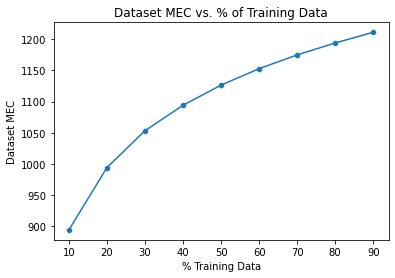

In [11]:
proportions = np.arange(0.1, 1, 0.1)
mec_list = []
for i in proportions:
    mec_list.append(capacity_req(fashion_mnist.sample(frac=i, axis=0)))
plt.title("Dataset MEC vs. % of Training Data")
plt.xlabel("% Training Data")
plt.ylabel("Dataset MEC")
sns.lineplot(x=proportions * 100, y=mec_list)
sns.scatterplot(x=proportions * 100, y=mec_list);

## Algorithm 2

We tabularize the dataset as a dictionary with 60000 rows. Each row has 1 out of 10 labels. Then at worst case memorization, our machine leaner need to memorize $10^{60000}$ labeling functions and thus need $log_2(10^{60000})$ bits

In [8]:
def max_capacity_req_dict(df):
    num_rows = len(df)                # number of data points
    num_classes = len(df['label'].unique())
    max_cap_req = num_rows * math.log(num_classes, 2)
    print("Max Capacity Requirement (dict):", max_cap_req)

In [9]:
max_capacity_req_dict(fashion_mnist)

Max Capacity Requirement (dict): 199315.68569324174
